# Imports

In [1]:
from data_classes import LAQNData, HealthData, MetData, IncomeData, LondonGeoData
from os import path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from shapely.geometry import LineString
import requests
import geopandas as gpd
import numpy as np
import networkx as nx
import torch
import torch_geometric

/home/users/mwlw3/miniconda3/envs/AQmort/lib/python3.8/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


# Load datasets

In [2]:
species = "NO2"
region = "London"
NO2 = LAQNData(species, region)

In [3]:
income = IncomeData()

In [4]:
met = MetData("Heathrow")

In [5]:
geography = LondonGeoData()

In [61]:
mort = HealthData()

## LAQN

In [32]:
# daily_NO2_df = NO2.read("laqn-resample")
# daily_NO2_df.head(5)

Spatially aggregate the LAQN data at the local authority level, with implementation of the algorithm used in Schwartz, 2000:

In [ ]:
# aggregated_NO2_df = NO2.local_authority_aggregation_and_log()

Load the spatially aggregated LAQN data:

In [148]:
aggregated_NO2_df = NO2.read("laqn-local-authority")

(8401, 33)


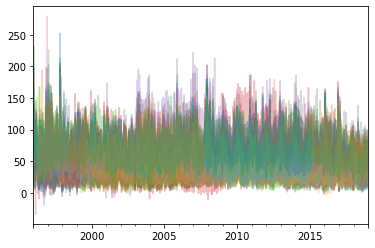

In [ ]:
print(aggregated_NO2_df.shape)
aggregated_NO2_df.plot(alpha=0.3)
plt.legend().remove()
plt.show()

## GDHI

In [8]:
daily_income_df = income.read("income-resample")

Rename the local authorities in the income metadata using the LAQN metadata:

In [76]:
# income_metadata_df = income.rename_local_authority_districts_and_log(reference="use_LAQN")
income_metadata_df = income.read("income-metadata")

## Meteorology

In [172]:
# daily_met_df = met.resample_time_and_log(daily_income_df.index)
variables = ["temperature", "dew_point", "humidity", "precip", "wind_dir", "wind_speed", "peak_gust", "pressure"]
daily_met_df = met.read(variables, "met-resample")

## London local authority shapefile

Rename the London local authorities shapefile using the income metadata:

In [ ]:
# london_authorities_gdf = geography.download_and_log()
# london_authorities_gdf = geography.rename_local_authority_districts_and_log(income_metadata_df["local_authority"].tolist(), "GDHI")
# london_authorities_gdf = geography.read("london-local-authorities-renamed")

Identify neighbouring local authorities:

In [75]:
# london_authorities_gdf, edge_pairs = geography.get_local_authority_neighbour_edges_and_log()
london_authorities_gdf = geography.read("london-local-authorities-neighbours")

In [7]:
edge_pairs = geography.read("edge-pairs-array")

## Mortality

In [64]:
mortality_df = mort.read("mortality-scaled")

# Missing data

## Check missing data (NaN values)

### LAQN

In [16]:
len(aggregated_NO2_df)

8401

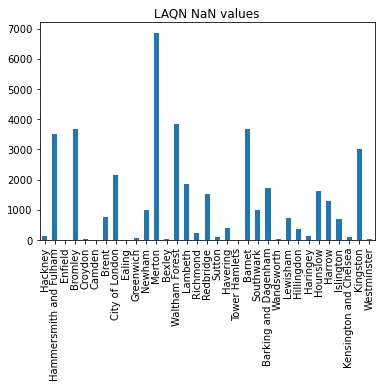

In [60]:
aggregated_NO2_df.isna().sum().plot.bar()
plt.title("LAQN NaN values")
# plt.yscale("log")
plt.show()

In [18]:
local_authority = "Kingston"

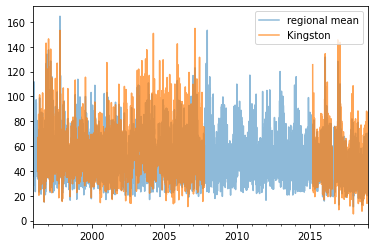

In [19]:
aggregated_NO2_df.mean(axis=1).plot(label="regional mean", alpha=0.5)
aggregated_NO2_df[local_authority].plot(alpha=0.7)
plt.legend()
plt.show()

#### Filling in data gaps using seasonal cycles and regional mean

##### Seasonal decomposition algorithm

In [20]:
from statsmodels.api import tsa

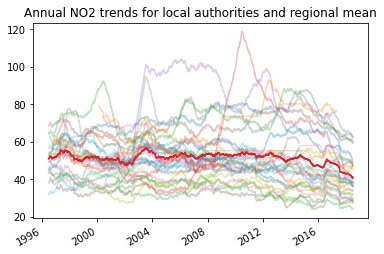

In [21]:
decomp_dict = {}

decomp = tsa.seasonal_decompose(aggregated_NO2_df.mean(axis=1).dropna(how="any"), model="additive", period=365)
decomp_df = pd.DataFrame({"observed":decomp.observed, "trend":decomp.trend, "seasonal":decomp.seasonal, "residual":decomp.resid})
decomp_dict["regional_mean"] = decomp_df

for la in aggregated_NO2_df.columns:
    decomp = tsa.seasonal_decompose(aggregated_NO2_df[la].dropna(how="any"), model="additive", period=365)
    decomp_df = pd.DataFrame({"observed":decomp.observed, "trend":decomp.trend, "seasonal":decomp.seasonal, "residual":decomp.resid})
    decomp_dict[la] = decomp_df
    decomp_dict[la].trend.plot(label=f"{la} trend", alpha=0.3)
    
decomp_dict["regional_mean"].trend.plot(label="regional mean trend")
# plt.legend(loc="upper right")
plt.title("Annual NO2 trends for local authorities and regional mean")
plt.show()


What if I use linear regression to map between the regional annual trend and the annual trends at the local authority level?

##### Linear regression

In [22]:
from sklearn.linear_model import LinearRegression

###### Annual trend

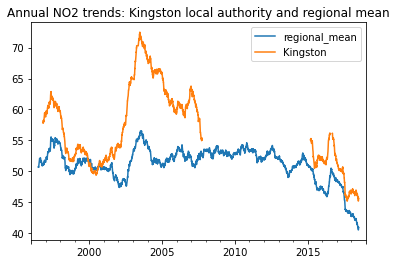

Model coefficient: 1.5825319520871393


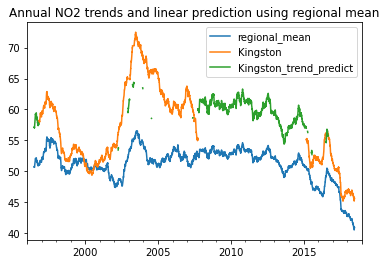

In [23]:
df = pd.concat([decomp_dict["regional_mean"].trend, decomp_dict[local_authority].trend], axis=1)
df.columns = ["regional_mean", local_authority]
df.plot()
plt.title(f"Annual NO2 trends: {local_authority} local authority and regional mean")
plt.show()
x = df.dropna()["regional_mean"].values.reshape(-1,1)
y = df.dropna()[local_authority].values
model = LinearRegression().fit(x, y)
print("Model coefficient:", model.coef_[0])
x_predict = df.loc[df[local_authority].isna()].dropna(subset="regional_mean")["regional_mean"].values.reshape(-1,1)
y_predict = model.predict(x_predict)
trend_df = pd.DataFrame(y_predict, index=df.loc[df[local_authority].isna()].dropna(subset="regional_mean").index, 
                         columns=[f"{local_authority}_trend_predict"])
df = pd.concat([df, trend_df], axis=1)
df.plot()
plt.title("Annual NO2 trends and linear prediction using regional mean")
plt.show()

###### Seasonal component

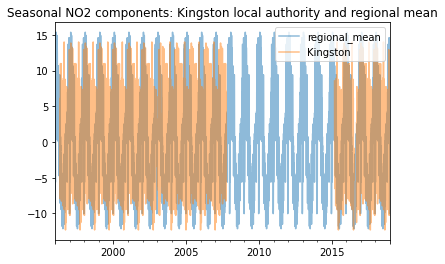

Model coefficient: 0.0658792394055598


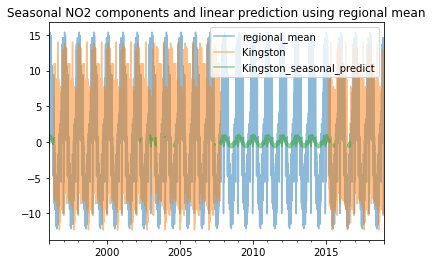

In [24]:
df = pd.concat([decomp_dict["regional_mean"].seasonal, decomp_dict[local_authority].seasonal], axis=1)
df.columns = ["regional_mean", local_authority]
df.plot(alpha=0.5)
plt.title(f"Seasonal NO2 components: {local_authority} local authority and regional mean")
plt.show()
x = df.dropna()["regional_mean"].values.reshape(-1,1)
y = df.dropna()[local_authority].values
model = LinearRegression().fit(x, y)
print("Model coefficient:", model.coef_[0])
x_predict = df.loc[df[local_authority].isna()].dropna(subset="regional_mean")["regional_mean"].values.reshape(-1,1)
y_predict = model.predict(x_predict)
seasonal_df = pd.DataFrame(y_predict, index=df.loc[df[local_authority].isna()].dropna(subset="regional_mean").index, 
                         columns=[f"{local_authority}_seasonal_predict"])
df = pd.concat([df, seasonal_df], axis=1)
df.plot(alpha=0.5)
plt.title("Seasonal NO2 components and linear prediction using regional mean")
plt.show()

In [25]:
predict_df = pd.concat([aggregated_NO2_df[local_authority], trend_df, seasonal_df], axis=1) 
predict_df[f"{local_authority}_prediction"] = predict_df[f"{local_authority}_trend_predict"] + predict_df[f"{local_authority}_seasonal_predict"]

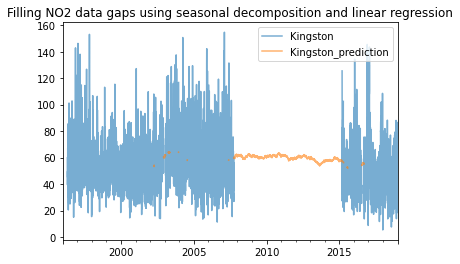

In [26]:
predict_df[local_authority].plot(alpha=0.6)
predict_df[f"{local_authority}_prediction"].plot(alpha=0.6)
plt.legend()
plt.title("Filling NO2 data gaps using seasonal decomposition and linear regression")
plt.show()

I believe this doesn't work because I'm not including the residuals from the seasonal decomposition, which contribute a lot. So what if I just do a straight linear regression from the regional mean to the local authority concentration?

###### No decomposition

In [27]:
regression_coefs = pd.DataFrame(columns=["local_authority", "coefficient"])

for local_authority in aggregated_NO2_df.columns:
    df = pd.concat([aggregated_NO2_df[local_authority], aggregated_NO2_df.mean(axis=1)], axis=1)
    df.columns = [local_authority, "regional_mean"]
    x = df.dropna()["regional_mean"].values.reshape(-1,1)
    y = df.dropna()[local_authority].values
    model = LinearRegression().fit(x, y)
    regression_coefs = pd.concat([regression_coefs, pd.DataFrame(data={"local_authority":[local_authority], "coefficient":[model.coef_[0]]})], ignore_index=True)

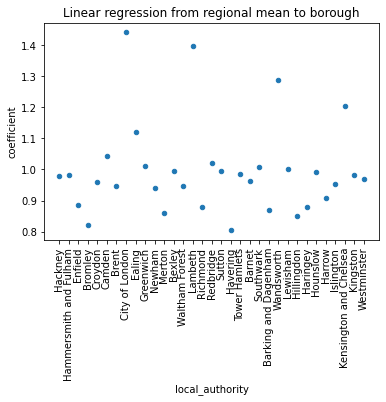

In [28]:
regression_coefs.plot.scatter(x="local_authority", y="coefficient")
plt.xticks(rotation=90)
plt.title("Linear regression from regional mean to borough")
plt.show()

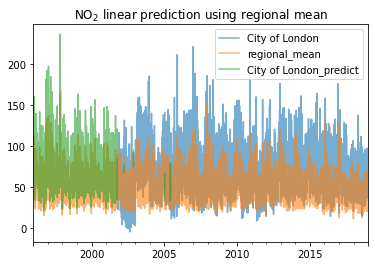

In [29]:
local_authority = "City of London"
df = pd.concat([aggregated_NO2_df[local_authority], aggregated_NO2_df.mean(axis=1)], axis=1)
df.columns = [local_authority, "regional_mean"]
x = df.dropna()["regional_mean"].values.reshape(-1,1)
y = df.dropna()[local_authority].values
model = LinearRegression().fit(x, y)
x_predict = df.loc[df[local_authority].isna()].dropna(subset="regional_mean")["regional_mean"].values.reshape(-1,1)
y_predict = model.predict(x_predict)
predict_df = pd.DataFrame(y_predict, index=df.loc[df[local_authority].isna()].dropna(subset="regional_mean").index, 
                         columns=[f"{local_authority}_predict"])
df = pd.concat([df, predict_df], axis=1)
df.plot(alpha=0.6)
plt.title("NO$_2$ linear prediction using regional mean")
plt.show()

### Income data

In [71]:
daily_income_df.isna().sum().sum()

0

No gaps in the GDHI dataset.

### Meteorological data

In [31]:
len(daily_met_df)

7671

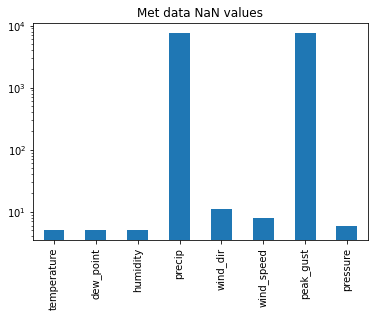

In [56]:
daily_met_df.isna().sum().plot.bar()
plt.title("Met data NaN values")
plt.yscale("log")
plt.show()

Exclude the precipitation and peak gust datasets.

### Mortality data

In [69]:
mortality_df.isna().sum()

deaths    0
dtype: int64

No gaps in the mortality dataset.

## Fill data gaps

### LAQN

One-hot encode the position of NaN values for each local authority, then fill the NaNs with the regional mean for that day:

In [149]:
print("NaN values before fill: ", aggregated_NO2_df.isna().sum().sum())
regional_mean_df = aggregated_NO2_df.mean(axis=1)

for local_authority in aggregated_NO2_df.columns:
    aggregated_NO2_df = pd.concat([aggregated_NO2_df, 
                                   pd.get_dummies(aggregated_NO2_df[local_authority].isna()).rename(columns={True:f"missing_{local_authority}"}).drop(False, axis=1)], 
                                  axis=1)
    aggregated_NO2_df[local_authority].fillna(regional_mean_df, inplace=True)

print("NaN values after fill: ", aggregated_NO2_df.isna().sum().sum())

NaN values before fill:  40434
NaN values after fill:  0


### Met data

Drop the precipiation and peak gust columns, as these have no data:

In [173]:
daily_met_df.drop(["precip", "peak_gust"], axis=1, inplace=True)

In [174]:
print("NaN values before fill: ", daily_met_df.isna().sum().sum())
for variable in daily_met_df.columns:
    daily_met_df = pd.concat([daily_met_df, pd.get_dummies(daily_met_df[variable].isna()).rename(columns={True:f"missing_{variable}"}).drop(False, axis=1)], axis=1)
daily_met_df.interpolate(inplace=True)
print("NaN values after fill: ", daily_met_df.isna().sum().sum())

NaN values before fill:  40
NaN values after fill:  0


# Graphs

Illustrate the graph setup over Greater London:

In [33]:
gdf = gpd.GeoDataFrame(edge_pairs.transpose(), columns=["x", "y"])

for column in gdf.columns:
    gdf[column] = gdf[column].map(london_authorities_gdf.centroid)

gdf.set_geometry([LineString(xy) for xy in zip(gdf.x, gdf.y)], inplace=True)

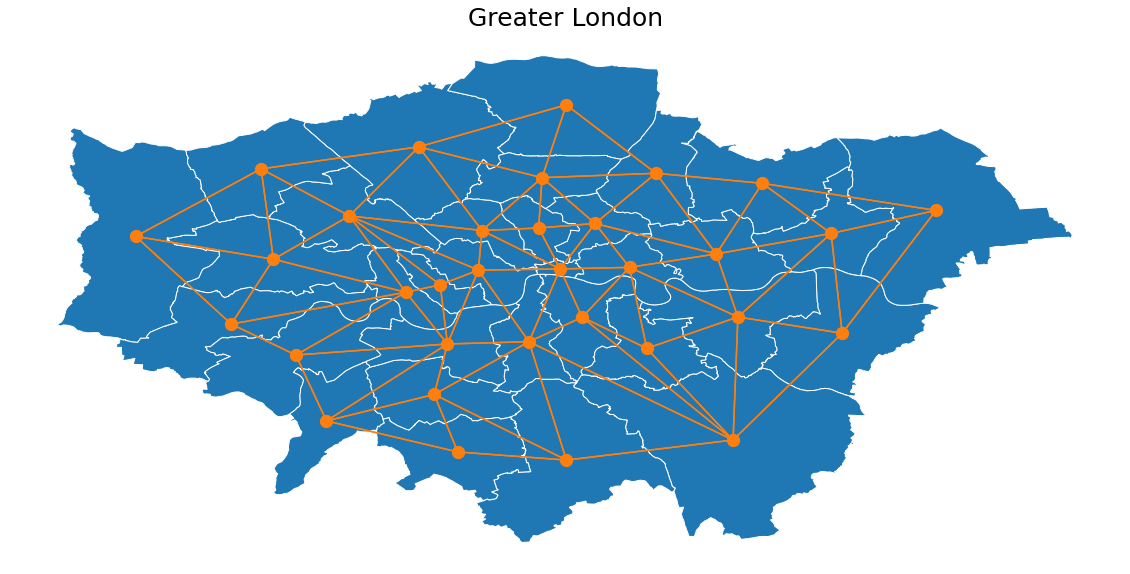

In [34]:
fig, ax = plt.subplots(figsize=(20, 15))

london_authorities_gdf.plot(ax=ax, edgecolors="w")
gdf.plot(ax=ax, color="tab:orange")
london_authorities_gdf.centroid.plot(ax=ax, marker="o", markersize=150, facecolors="tab:orange", edgecolors="tab:orange")
plt.axis("off")
plt.title("Greater London", fontsize=25)
plt.show()

Note that I haven't currently specified edge length.

CR notes: Node attribute prediction for filling in data gaps.

Set up the node connections:

In [35]:
# london_authorities_gdf, edge_pairs = geography.get_local_authority_neighbour_edges_and_log()

In [36]:
edge_index = torch.tensor(edge_pairs, dtype=torch.long)

In [37]:
node_index = london_authorities_gdf.index.values.reshape(-1,1)
x = torch.tensor(node_index, dtype=torch.float)

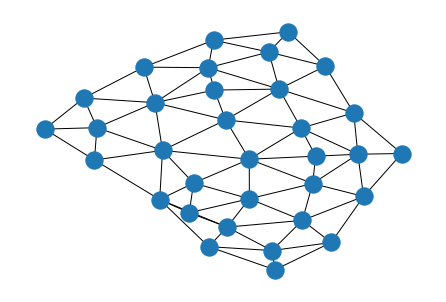

In [38]:
data = torch_geometric.data.Data(x=x, edge_index=edge_index)
graph = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(graph)

### Input feature processing to numpy arrays

Match up the date ranges for the local authority-level income and NO2 data:

In [39]:
def date_trim(df, start, end):
    df = df.loc[df.index >= start]
    df = df.loc[df.index <= end]
    return df

In [40]:
start, end = daily_income_df.index.min(), daily_income_df.index.max()

aggregated_NO2_datetrim_df = date_trim(aggregated_NO2_df, start, end)

In [41]:
local_authority_list = [] 

for i in london_authorities_gdf.index:
    local_authority = london_authorities_gdf.iloc[i]["local_authority"]
    income_dataset_code = income_metadata_df.loc[income_metadata_df["local_authority"]==local_authority].index.values[0]
    daily_income_array = daily_income_df[income_dataset_code].values
    daily_NO2_array = aggregated_NO2_datetrim_df[local_authority].values
    node_array = np.array([daily_NO2_array, daily_income_array])
    local_authority_list.append(node_array)
input_array = np.array(local_authority_list)

In [42]:
input_array.shape

(33, 2, 7671)

In [43]:
np.isnan(input_array).sum()

33315

Meteorological data for the whole Greater London region:

In [44]:
selected_variables = []
for column in daily_met_df.columns:
    nan_num = np.isnan(daily_met_df[column]).sum()
    print(f"{column}: {nan_num} NaN values")
    if nan_num < (len(daily_met_df) * 0.1):
        selected_variables.append(column)
print(selected_variables)

temperature: 5 NaN values
dew_point: 5 NaN values
humidity: 5 NaN values
precip: 7671 NaN values
wind_dir: 11 NaN values
wind_speed: 8 NaN values
peak_gust: 7671 NaN values
pressure: 6 NaN values
['temperature', 'dew_point', 'humidity', 'wind_dir', 'wind_speed', 'pressure']


In [45]:
for variable in selected_variables:
    array = np.tile(daily_met_df[variable].values, (len(london_authorities_gdf), 1, 1))
    input_array = np.concatenate((input_array, array), axis=1)

print(input_array.shape)

(33, 8, 7671)


In [46]:
nan_percent = np.isnan(input_array).sum() / len(input_array.flatten()) * 100
print(f"{np.round(nan_percent, 2)}% of all data points are NaN values.")

1.71% of all data points are NaN values.


Torch geometric data object:

In [47]:
data = torch_geometric.data.Data(x=input_array, edge_index=edge_index)

In [48]:
data

Data(x=[33, 8, 7671], edge_index=[2, 164])

In [49]:
# One data point instance is indexed by:
datapoint = input_array[:, :, 0].shape
torch_geometric.data.Data(x=datapoint, edge_index=edge_index)

Data(x=[2], edge_index=[2, 164])

In [50]:
# Have a look at the torch_geometric.data.Dataset() class.